# Fraud detection using credit card transcation data

## 1. Load the data



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,6)})

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')

## 2 EDA (preivous file)

## 3. Feature Engineering (Case 3)



In [3]:
## 3.1 posEntryMode
df['posEM_new'] = np.where(df['posEntryMode'] == '', '999',df['posEntryMode'])

## 3.2 transactionAmount and creditLimit
df['amountOver'] = np.where(df['transactionAmount'] > df['creditLimit'], 1, 0)

## 3.3 cardCVV and enteredCVV
df['cvvNotSame'] =  np.where(df['cardCVV'] != df['enteredCVV'], 1, 0)

## 3.4 DateTime
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
df['hour'] = df['transactionDateTime'].dt.hour

##3.5 Create a new dataframe
df1 = df[['isFraud','cvvNotSame','amountOver', 'posEM_new', 'hour', 'transactionAmount', 'availableMoney', 'cardPresent', 'transactionType']]
df1 = pd.get_dummies(columns=['posEM_new'], data = df1)
df1 = pd.get_dummies(columns=['transactionType'], data = df1)
df_final = df1.dropna()
df_final.head()

,isFraud,cvvNotSame,amountOver,hour,transactionAmount,availableMoney,cardPresent,posEM_new_2.0,posEM_new_5.0,posEM_new_80.0,posEM_new_9.0,posEM_new_90.0,posEM_new_nan,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
0,False,0,0,14,98.55,5000.0,False,1,0,0,0,0,0,0,1,0
1,False,0,0,5,74.51,5000.0,True,0,0,0,1,0,0,0,1,0
2,False,0,0,9,7.47,5000.0,False,0,0,0,1,0,0,0,1,0
3,False,0,0,2,7.47,5000.0,False,0,0,0,1,0,0,0,1,0
4,False,0,0,21,71.18,5000.0,True,1,0,0,0,0,0,0,1,0


## 4 Modeling

For this fraud detection task, I will use ROC_AUC as the primary metric.

## 4.1 Train-Test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_final.drop('isFraud', axis = 1),
                                                    df_final['isFraud'],
                                                    stratify = df_final['isFraud'],
                                                    test_size = 0.2,
                                                    random_state = 123)

In [5]:
print(X_train.shape)
print(X_test.shape)

(629090, 15)
(157273, 15)


In [6]:
print(y_train.mean())
print(y_test.mean())

0.015791063281883354
0.015787833893929664


## 4.2 Model1 - Logistics regression

In [7]:
clf_lr = LogisticRegression(max_iter=500)
clf_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
# 5-fold cross validation
cross_val_score(clf_lr, X_train, y_train, scoring = "roc_auc", cv = 5)

array([0.70442734, 0.69757369, 0.68259224, 0.70986962, 0.72341228])

In [9]:
# Other metrics
y_pred_lr = clf_lr.predict(X_test)
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_lr))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_lr))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_lr))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_lr))

accuracy:  0.9842058077355935
precision:  0.0
recall:  0.0
confusion matrix:  [[154789      1]
 [  2483      0]]


In [10]:
y_pred_p = clf_lr.predict_proba(X_test)
y_pred_p[0:10]

array([[0.99145119, 0.00854881],
       [0.98965944, 0.01034056],
       [0.99397077, 0.00602923],
       [0.98345956, 0.01654044],
       [0.99581172, 0.00418828],
       [0.99703376, 0.00296624],
       [0.99397353, 0.00602647],
       [0.9909292 , 0.0090708 ],
       [0.99258295, 0.00741705],
       [0.98970201, 0.01029799]])

In [11]:
# Replace the threshold with the percentage of the fraud transactions in the dataset
y_pred_lr = np.where(y_pred_p[:,1]> 0.016, 1,0)
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_lr))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_lr))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_lr))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_lr))

accuracy:  0.6171116466272024
precision:  0.02845521815122756
recall:  0.7015706806282722
confusion matrix:  [[95313 59477]
 [  741  1742]]


Logistic: ROC AUC=0.721


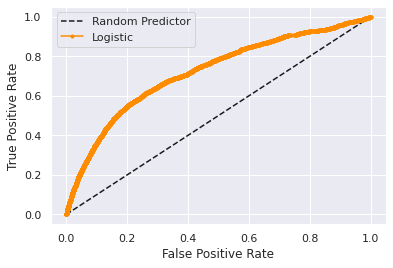

In [12]:
# Plot roc_auc
lr_probs = clf_lr.predict_proba(X_test)
 
# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
 
# Calculate scores area under curve
lr_auc = roc_auc_score(y_test,lr_probs)
 
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
 
# calculate the roc curve
fpr, tpr, thresholds = roc_curve(y_test,lr_probs)
 
# plot the roc curve for the model
plt.plot([0, 1], [0, 1], 'k--',label='Random Predictor')  # draw diag
plt.plot(fpr, tpr, marker='.', color='darkorange',label='Logistic') # draw ROC
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

I will use 0.721 as the base.

## 4.2.1  Model1 - Logistics regression (scaling)

In [13]:
# Scale the dataframe
min_max_scaler = MinMaxScaler()
df_final_scaled = min_max_scaler.fit_transform(df_final.values)
df_final2 = pd.DataFrame(df_final_scaled)
df_final2.columns = df_final.columns
df_final2.head()

,isFraud,cvvNotSame,amountOver,hour,transactionAmount,availableMoney,cardPresent,posEM_new_2.0,posEM_new_5.0,posEM_new_80.0,posEM_new_9.0,posEM_new_90.0,posEM_new_nan,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
0,0.0,0.0,0.0,0.608696,0.048992,0.117744,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.217391,0.037041,0.117744,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.391304,0.003714,0.117744,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.086957,0.003714,0.117744,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.913043,0.035386,0.117744,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(df_final2.drop('isFraud', axis = 1),
                                                    df_final2['isFraud'],
                                                    stratify = df_final2['isFraud'],
                                                    test_size = 0.2,
                                                    random_state = 123)

In [15]:
# Apply the logistic model
clf_lr = LogisticRegression(max_iter=500)
clf_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
# Replace the threshold
y_pred_p = clf_lr.predict_proba(X_test)
y_pred_lr = np.where(y_pred_p[:,1]> 0.016, 1,0)

In [17]:
# Other metrics
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_lr))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_lr))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_lr))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_lr))

accuracy:  0.6447260496080065
precision:  0.030479440008442084
recall:  0.697946033024567
confusion matrix:  [[99665 55125]
 [  750  1733]]


Logistic: ROC AUC=0.724


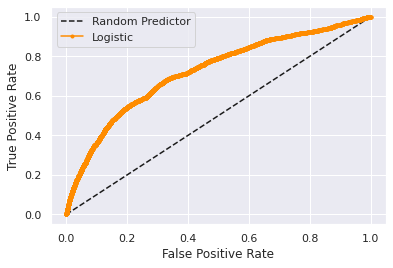

In [18]:
# Plot roc_auc
lr_probs = clf_lr.predict_proba(X_test)
 
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores  Area Under Cruve
lr_auc = roc_auc_score(y_test,lr_probs)
 
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
 
# calculate the roc curve
fpr, tpr, thresholds = roc_curve(y_test,lr_probs)
 
# plot the roc curve for the model
plt.plot([0, 1], [0, 1], 'k--',label='Random Predictor')  # draw diag
plt.plot(fpr, tpr, marker='.', color='darkorange',label='Logistic') # draw ROC
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Compare the 2 roc_auc results before and after scaling the dataframe, it can be concluded that scaling the dataframe increases the value of the metric. Therefore, I will use the scaling dataframe in the following modeling experiments.

# 4.3 XGBoost

In [19]:
# Fit the model
xgb_clf = XGBClassifier(n_estimators=300, 
                        learning_rate=0.05
                        )
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
# Replace the threshold
y_pred_xgb = xgb_clf.predict_proba(X_test)
y_pred_xgb = np.where(y_pred_xgb[:,1]> 0.016, 1,0)

In [21]:
# Other metrics
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_xgb))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_xgb))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_xgb))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_xgb))

accuracy:  0.7335652019100545
precision:  0.03732394366197183
recall:  0.6403544099879178
confusion matrix:  [[113780  41010]
 [   893   1590]]


Logistic: ROC AUC=0.737


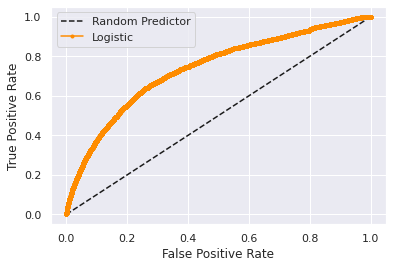

In [22]:
# Plot roc_auc
lr_probs = xgb_clf.predict_proba(X_test)
 
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores area under the Curve
lr_auc = roc_auc_score(y_test,lr_probs)
 
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
 
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test,lr_probs)
 
# plot the roc curve for the model
plt.plot([0, 1], [0, 1], 'k--',label='Random Predictor')  # draw diag
plt.plot(fpr, tpr, marker='.', color='darkorange',label='Logistic') # draw ROC
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [23]:
# Grid search
xgb_clf = XGBClassifier()

xgb_param_grid = {'learning_rate': np.arange(0.05, 0.15, 0.05),
                  'n_estimators': np.arange(200, 400, 100)
                  }

random_xgb = RandomizedSearchCV(estimator=xgb_clf, 
                                    param_distributions=xgb_param_grid,
                                    n_iter=100, 
                                    scoring='roc_auc', 
                                    cv=2,
                                    verbose=1,
                                    n_jobs=-1
                                    )
random_xgb.fit(X_train, y_train)
print("Best parameters found: ",random_xgb.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  6.0min finished


Best parameters found:  {'n_estimators': 200, 'learning_rate': 0.05}


Logistic: ROC AUC=0.737


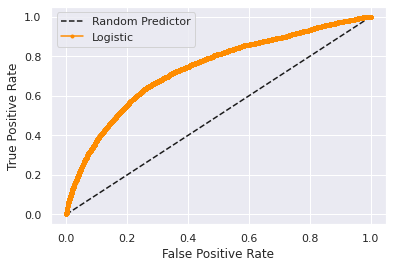

In [24]:
# Use the best parameter to calculate roc_auc
xgb_clf = XGBClassifier(n_estimators=200, 
                        learning_rate=0.05
                        )
xgb_clf.fit(X_train, y_train)

lr_probs = xgb_clf.predict_proba(X_test)
 
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
 
# calculate scores area Under Cruve
lr_auc = roc_auc_score(y_test,lr_probs)
 
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
 
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test,lr_probs)
 
# plot the roc curve for the model
plt.plot([0, 1], [0, 1], 'k--',label='Random Predictor')  # draw diag
plt.plot(fpr, tpr, marker='.', color='darkorange',label='Logistic') # draw ROC
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## 4.4 LightGBM

In [25]:
# Fit the model
lgb_clf = LGBMClassifier(n_estimators = 200, 
                         max_depth=10,
                         learning_rate = 0.1
                         )
lgb_clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [26]:
# Replace the threshold
y_pred_lgb = lgb_clf.predict_proba(X_test)
y_pred_lgb = np.where(y_pred_lgb[:,1]> 0.016, 1,0)

In [27]:
# Other metrics
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_lgb))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_lgb))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_lgb))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_lgb))

accuracy:  0.7102617741125304
precision:  0.03493016126594849
recall:  0.6516310914216673
confusion matrix:  [[110087  44703]
 [   865   1618]]


Logistic: ROC AUC=0.733


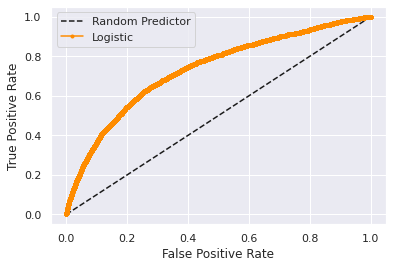

In [28]:
# Plot roc_auc
lr_probs = lgb_clf.predict_proba(X_test)
 
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
 
# calculate scores area under curve
lr_auc = roc_auc_score(y_test,lr_probs)
 
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
 
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test,lr_probs)
 
# plot the roc curve for the model
plt.plot([0, 1], [0, 1], 'k--',label='Random Predictor')  # draw diag
plt.plot(fpr, tpr, marker='.', color='darkorange',label='Logistic') # draw ROC
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [29]:
# Grid search
lgb_clf = LGBMClassifier()

lgb_param_grid = {'learning_rate': np.arange(0.05, 0.15, 0.05),
                  'n_estimators': np.arange(200, 600, 200),
                  'max_depth': [5,10]
                  }

random_lgb = RandomizedSearchCV(estimator=lgb_clf, 
                                    param_distributions=lgb_param_grid,
                                    n_iter=100, 
                                    scoring='roc_auc', 
                                    cv=2, 
                                    verbose=1,
                                    n_jobs=-1
                                    )
random_lgb.fit(X_train, y_train)
print("Best parameters found: ",random_lgb.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.5min finished


Best parameters found:  {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05}


Logistic: ROC AUC=0.736


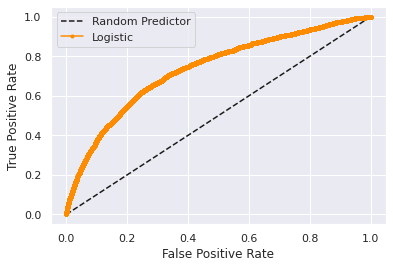

In [30]:
# Use the best parameter to caculate roc_auc
lgb_clf = LGBMClassifier(n_estimators = 200, 
                         max_depth=10,
                         learning_rate = 0.05
                         )
lgb_clf.fit(X_train, y_train)

lr_probs = lgb_clf.predict_proba(X_test)
 
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
 
# calculate scores area under curve
lr_auc = roc_auc_score(y_test,lr_probs)
 
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
 
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test,lr_probs)
 
# plot the roc curve for the model
plt.plot([0, 1], [0, 1], 'k--',label='Random Predictor')  # draw diag
plt.plot(fpr, tpr, marker='.', color='darkorange',label='Logistic') # draw ROC
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

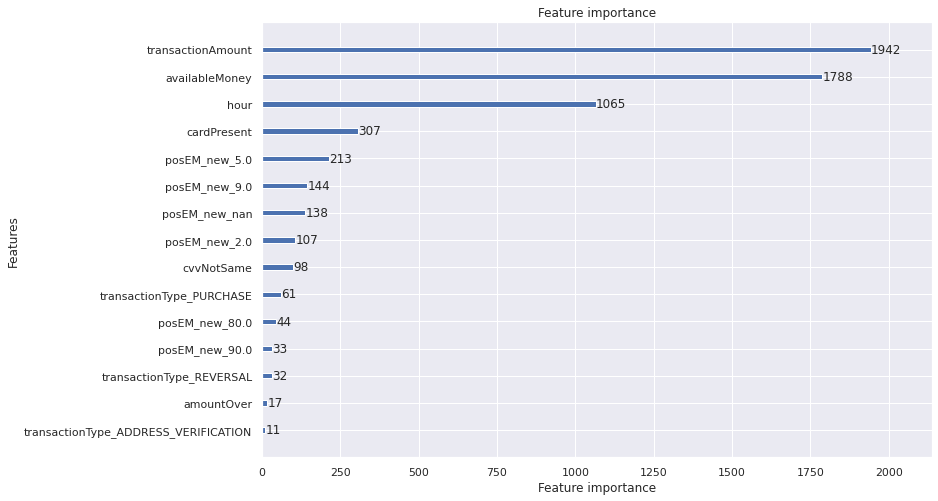

In [31]:
sns.set(rc={'figure.figsize':(12,8)})
plot_importance(lgb_clf)

In this feature combination, XGBoost achieves 0.737 for the roc_auc, outperforming logistics regression and LightGBM.